In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.ticker as ticker
import pandas as pd
import glob
import re
# Statistics
from scipy.stats import norm
from scipy.special import factorial
# Parallel
from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm import tqdm

In [2]:
# Matplotlib customize
plt.rcParams['figure.figsize'] = [6,5]
plt.rcParams['figure.dpi'] = 100

plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 20

plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['lines.markersize'] = 4

plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

plt.rcParams['legend.fontsize'] = 12
plt.rcParams['legend.markerscale'] = 1.5
plt.rcParams['legend.borderpad'] = 0.6
plt.rcParams['legend.framealpha'] = 0.7

In [3]:
Data = []
Mass = np.array([])

for f in glob.glob('Data/*.csv'):
    #print(f)
    
    data = pd.read_csv(f,sep=',')
    Data.append(data)

    # Extraer los últimos tres números del nombre del archivo
    match = re.search(r'(\d{3})\.csv$', f)
    if match:
        Mass = np.append(Mass, float(match.group(1)))

# Emparejar los numeros con los dataframes
paired = list(zip(Mass,Data))

# Ordenar los pares segun las masas
Mass_sorted = sorted(paired, key=lambda x: x[0])

# Separar de nuevo los numeros y los dataFrames
Mass_sorted, Data = zip(*Mass_sorted)

# Numpy array
Mass = np.array(Mass_sorted)

print(Mass)

[100. 106. 112. 118. 124. 130. 136. 142. 148. 154. 160.]


In [4]:
# Estimator definition
def GetLnQ(n,b,s,mu):
    return 2*(mu*s - n*np.log( 1 + (mu*s/b) ))

In [5]:
def GetJointLnQ(LnQ,mu,Null=True):

    Q = 0.

    for c in range(N):

        if Null:
            ntoy = np.random.poisson(b[c])
        else:
            ntoy = np.random.poisson( mu*s[c] + b[c] )

        Q += LnQ(ntoy,b[c],s[c],mu)

    return Q

In [6]:
def GetObsJointLnQ(LnQ,mu,Expected = True):

    Q = 0.
    
    for c in range(N):

        if Expected: # Observed events are the expected background
            Q += LnQ( b[c], b[c], s[c], mu )
        else:
            Q += LnQ( n[c], b[c], s[c], mu )

    return Q

In [10]:
def Sampler(mu, Ntoys = int(1e3)):

    q0 = np.zeros(Ntoys)
    q1 = np.zeros(Ntoys)

    for i in range(Ntoys):
        q0[i] = GetJointLnQ(GetLnQ, mu)  #H0
        q1[i] = GetJointLnQ(GetLnQ, mu, Null = False) #H1
    
    return q0,q1

In [11]:
def GetPValue(data,Qobs, Null = True):

    if Null:
        count_below_threshold = np.sum( data <= Qobs )
        p_value = count_below_threshold/data.shape[0]

    else:
        count_above_threshold = np.sum( data >= Qobs )
        p_value = count_above_threshold / data.shape[0]

    return p_value

In [12]:
# Funcion en paralelo
def GetCls_for_mu(i, mu, Expected = False):

    Qobs = GetObsJointLnQ(GetLnQ,mu,Expected)
    q0,q1 = Sampler(mu)
    
    p0 = GetPValue(q0, Qobs, Null = True)
    p1 = GetPValue(q1, Qobs, Null = False)

    Clb = 1 - p0
    Clsb = p1

    Cls = Clsb/Clb

    return i,Clsb

In [13]:
def GetCls_parallel(mu, Expected=False, num_processors=None):

    p_value = np.zeros_like(mu)

    with ProcessPoolExecutor(max_workers=num_processors) as executor:

        futures = []

        # Crear las tareas (futuras) para cada valor de mu
        for i in range(mu.shape[0]):

            futures.append(executor.submit(GetCls_for_mu, i, mu[i], Expected))

        # Recolectar los resultados a medida que se completan
        for future in tqdm(as_completed(futures), total=len(futures)):
            i, Clsb = future.result()
            p_value[i] = Clsb

    return p_value

In [14]:
# Upper limit
def GetUpperLimit(mu,Cls,alpha = 0.05):

    i = np.where( Cls <= alpha )

    if len(i[0]) == 0:
        print('--- Cls is never less than alpha --- ')
        return 0.
    else:
        i = i[0][0]

    # Saving the indez where pvalues is less than the critical value

    x0 = mu[i-1]
    x1 = mu[i]
    fx0 = Cls[i-1]
    fx1 = Cls[i]

    # Compute the slope
    m = (fx1-fx0)/(x1-x0)

    if m == 0:
        print('--- Problem with the scan ---')
        return 0.

    # 1D Polynomial interpolation
    mup = (alpha - fx0)/m + x0

    return mup

In [17]:
# Estructura de datos para guardar
MatrizDatos = np.zeros((Mass.shape[0],7))
MatrizDatos[:,0] = Mass
MatrizDatos

array([[100.,   0.,   0.,   0.,   0.,   0.,   0.],
       [106.,   0.,   0.,   0.,   0.,   0.,   0.],
       [112.,   0.,   0.,   0.,   0.,   0.,   0.],
       [118.,   0.,   0.,   0.,   0.,   0.,   0.],
       [124.,   0.,   0.,   0.,   0.,   0.,   0.],
       [130.,   0.,   0.,   0.,   0.,   0.,   0.],
       [136.,   0.,   0.,   0.,   0.,   0.,   0.],
       [142.,   0.,   0.,   0.,   0.,   0.,   0.],
       [148.,   0.,   0.,   0.,   0.,   0.,   0.],
       [154.,   0.,   0.,   0.,   0.,   0.,   0.],
       [160.,   0.,   0.,   0.,   0.,   0.,   0.]])

In [47]:
# Running the upper limits for each signal points

for i, data in enumerate(Data):

    print('--- Estimating Limits for ---', Mass[i])
    labels = list(data.keys())
    n = np.array(data[labels[0]])
    b = np.array(data[labels[1]])
    s = np.array(data[labels[2]])
    N = n.shape[0]

    # SetPOI scan
    mu = np.linspace(0.1,2,10)
    Op_value = GetCls_parallel(mu,Expected=False,num_processors=8)
    Ep_value = GetCls_parallel(mu,Expected=True,num_processors=8)

    ExpectedLimit = GetUpperLimit(mu,Ep_value)
    ObservedLimit = GetUpperLimit(mu,Op_value)

    # For Errors
    Qe = GetObsJointLnQ(GetLnQ,ExpectedLimit,True)
    sigma = ExpectedLimit / np.sqrt(Qe)

    if ExpectedLimit - 2*sigma > 0:
        MatrizDatos[i,1] = ExpectedLimit - 2*sigma
    else:
        MatrizDatos[i,1] = 0.
        
    MatrizDatos[i,2] = ExpectedLimit - 1*sigma
    MatrizDatos[i,3] = ExpectedLimit
    MatrizDatos[i,4] = ExpectedLimit + 1*sigma
    MatrizDatos[i,5] = ExpectedLimit + 2*sigma
    # Observed Limit
    MatrizDatos[i,6] = ObservedLimit

--- Estimating Limits for --- 100.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 14.54it/s]

--- Estimating Limits for --- 106.0



100%|█████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.62it/s]

--- Estimating Limits for --- 112.0



100%|█████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.17it/s]

--- Estimating Limits for --- 118.0



100%|█████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.37it/s]


--- Estimating Limits for --- 124.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.24it/s]


--- Estimating Limits for --- 130.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.79it/s]


--- Estimating Limits for --- 136.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.28it/s]

--- Estimating Limits for --- 142.0



100%|█████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.44it/s]

--- Estimating Limits for --- 148.0



100%|█████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.05it/s]

--- Estimating Limits for --- 154.0



100%|█████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 14.48it/s]

--- Estimating Limits for --- 160.0



100%|█████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.12it/s]


In [48]:
DataFinal = pd.DataFrame(MatrizDatos)
DataFinal.columns = ['Mass','-2sigma','-1sigma','Expected','+1sigma','+2sigma','Observed']
DataFinal

,Mass,-2sigma,-1sigma,Expected,+1sigma,+2sigma,Observed
0,100.0,0.000000,0.269356,0.710598,1.151841,1.593084,0.512048
1,106.0,0.000000,0.192437,0.468951,0.745465,1.021980,0.324879
2,112.0,0.000000,0.211532,0.482863,0.754193,1.025524,0.490817
3,118.0,0.000000,0.190632,0.431746,0.672860,0.913975,1.132333
4,124.0,0.000000,0.160453,0.377083,0.593713,0.810343,1.362984
5,130.0,0.000000,0.135695,0.331410,0.527126,0.722841,0.870165
6,136.0,0.000000,0.121067,0.303023,0.484978,0.666933,0.325185
7,142.0,0.000000,0.129511,0.294071,0.458630,0.623189,0.237308
8,148.0,0.000000,0.126526,0.283694,0.440863,0.598031,0.399297
9,154.0,0.002092,0.138614,0.275137,0.411660,0.548182,0.425714


In [49]:
DataFinal.to_csv('UpperLimitMassScan.csv',index=False)

<Axes: xlabel='Mass', ylabel='Expected'>

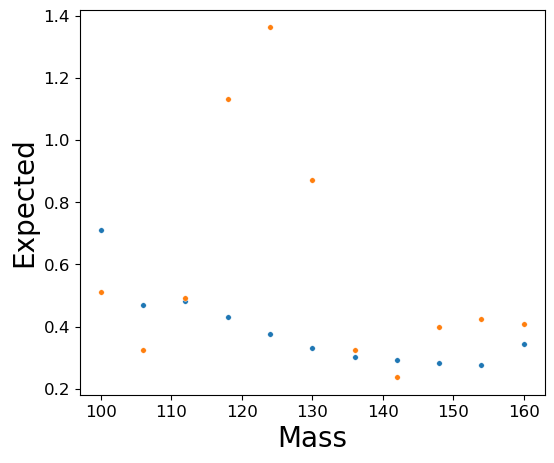

In [50]:
import seaborn as sns
sns.scatterplot(x='Mass',y='Expected',data = DataFinal)
sns.scatterplot(x='Mass',y='Observed',data = DataFinal)

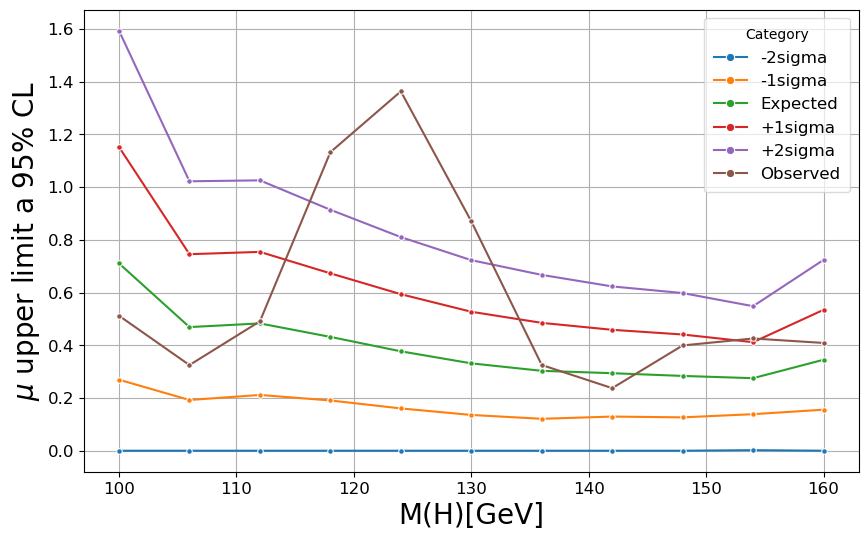

In [51]:
# Convertir el DataFrame a un formato largo para que se pueda graficar fácilmente
data_melted = DataFinal.melt(id_vars='Mass', var_name='Category', value_name='Value')

# Crear el gráfico de líneas
plt.figure(figsize=(10, 6))
sns.lineplot(data=data_melted, x='Mass', y='Value', hue='Category', marker="o")

# Añadir etiquetas y título
plt.xlabel('M(H)[GeV]')
plt.ylabel(r'$\mu$ upper limit a $95\%$ CL')
plt.title('')
plt.grid(True)

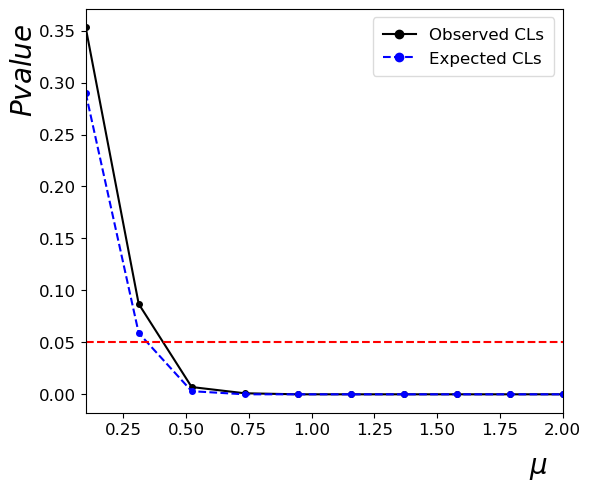

In [43]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.plot(mu,Op_value,color='k',marker='o',label='Observed CLs')
ax.plot(mu,Ep_value,'--',color='b',marker='o',label='Expected CLs')

ax.axhline(y=0.05,ls='--',color='r')

# Label X
ax.set_xlabel(r'$\mu$')
ax.xaxis.set_label_coords(0.95,-0.1)
ax.set_xlim(mu[0],mu[-1])

# Label Y
ax.set_ylabel(r'$Pvalue$')
ax.yaxis.set_label_coords(-0.1,0.85)

# Ajustar los márgenes automáticamente
plt.tight_layout()

#Legend
ax.legend(loc='upper right',bbox_to_anchor=(1,1),ncol=1,title='')

#
plt.savefig('UpperLimit_Scan.pdf')